# Previsão de fatalidade em um acidente
Classificação
Gravidade Fatal

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import impute 
from sklearn import preprocessing
from sklearn import compose
from sklearn import metrics
from sklearn import ensemble
from sklearn import pipeline
from sklearn import dummy
from sklearn import tree
import mlflow
import xgboost

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

In [ ]:
## fontes dos dados: https://dadosabertos.sp.gov.br/dataset/sinistros-infosiga
raw = pd.read_csv('data/sinistros_2022-2025.csv', encoding='latin-1', on_bad_lines='skip', sep=';', decimal=',')
sinistro = raw.copy()

In [3]:
sinistro.shape

(672524, 43)

In [4]:
sinistro.dtypes

id_sinistro                          int64
tipo_registro                       object
data_sinistro                       object
ano_sinistro                         int64
mes_sinistro                         int64
dia_sinistro                         int64
ano_mes_sinistro                    object
hora_sinistro                       object
logradouro                          object
numero_logradouro                   object
tipo_via                            object
latitude                           float64
longitude                          float64
municipio                           object
regiao_administrativa               object
tp_veiculo_bicicleta               float64
tp_veiculo_caminhao                float64
tp_veiculo_motocicleta             float64
tp_veiculo_nao_disponivel          float64
tp_veiculo_onibus                  float64
tp_veiculo_outros                  float64
tp_veiculo_automovel               float64
gravidade_nao_disponivel           float64
gravidade_l

In [5]:
sinistro.head(5)
## colunas de gravidade indicam quantidade de pessoas em tal situação

,id_sinistro,tipo_registro,data_sinistro,ano_sinistro,mes_sinistro,dia_sinistro,ano_mes_sinistro,hora_sinistro,logradouro,numero_logradouro,tipo_via,latitude,longitude,municipio,regiao_administrativa,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel,gravidade_nao_disponivel,gravidade_leve,gravidade_fatal,gravidade_ileso,gravidade_grave,administracao,conservacao,jurisdicao,tipo_acidente_primario,tp_sinistro_atropelamento,tp_sinistro_colisao_frontal,tp_sinistro_colisao_traseira,tp_sinistro_colisao_lateral,tp_sinistro_colisao_transversal,tp_sinistro_colisao_outros,tp_sinistro_choque,tp_sinistro_capotamento,tp_sinistro_engavetamento,tp_sinistro_tombamento,tp_sinistro_outros,tp_sinistro_nao_disponivel
0,1265457,NOTIFICACAO,01/01/2022,2022,1,1,2022/01,05:12,RUA VEREADOR NELSON GUIRALDELI,100.0,VIAS MUNICIPAIS,-22.434868,-46.824890,ITAPIRA,Campinas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PREFEITURA,PREFEITURA,MUNICIPAL,OUTROS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN
1,1275691,NOTIFICACAO,01/01/2022,2022,1,1,2022/01,05:19,AVENIDA JAPAO,5999.0,VIAS MUNICIPAIS,-23.575741,-46.220352,MOGI DAS CRUZES,Metropolitana de São Paulo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PREFEITURA,PREFEITURA,MUNICIPAL,NAO DISPONIVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
2,2464210,SINISTRO FATAL,01/01/2022,2022,1,1,2022/01,05:00,RUA LETICIA,272.0,VIAS MUNICIPAIS,-23.690987,-46.789733,SAO PAULO,Metropolitana de São Paulo,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,PREFEITURA,PREFEITURA,MUNICIPAL,COLISAO,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,S
3,1305958,SINISTRO NAO FATAL,01/01/2022,2022,1,1,2022/01,05:52,PRESID TANCREDO DE ALMEIDA NEVES,31.0,VIAS MUNICIPAIS,-23.401760,-46.720168,CAIEIRAS,Metropolitana de São Paulo,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,PREFEITURA,PREFEITURA,MUNICIPAL,OUTROS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN
4,2464234,SINISTRO FATAL,01/01/2022,2022,1,1,2022/01,07:10,AVENIDA DEPUTADO CANTIDIO SAMPAIO,7037.0,VIAS MUNICIPAIS,-23.435160,-46.717333,SAO PAULO,Metropolitana de São Paulo,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,PREFEITURA,PREFEITURA,MUNICIPAL,CHOQUE,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,S


In [6]:
sinistro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672524 entries, 0 to 672523
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id_sinistro                      672524 non-null  int64  
 1   tipo_registro                    672524 non-null  object 
 2   data_sinistro                    672524 non-null  object 
 3   ano_sinistro                     672524 non-null  int64  
 4   mes_sinistro                     672524 non-null  int64  
 5   dia_sinistro                     672524 non-null  int64  
 6   ano_mes_sinistro                 672524 non-null  object 
 7   hora_sinistro                    671757 non-null  object 
 8   logradouro                       671005 non-null  object 
 9   numero_logradouro                670258 non-null  object 
 10  tipo_via                         672524 non-null  object 
 11  latitude                         669873 non-null  float64
 12  lo

In [7]:
## removendo linhas duplicadas e colunas não desejadas
list(sinistro.columns)
to_remove = ['id_sinistro', 'tipo_acidente_primario',
             'ano_mes_sinistro', 'ano_sinistro',
             'logradouro', 'numero_logradouro',
             'municipio', 'regiao_administrativa',
             'administracao', 'conservacao',
             'jurisdicao', 'latitude',
             'longitude', 'tipo_registro']
sinistro.drop(columns=to_remove, inplace=True)
sinistro.drop_duplicates(inplace=True)

In [8]:
sinistro.columns

Index(['data_sinistro', 'mes_sinistro', 'dia_sinistro', 'hora_sinistro',
       'tipo_via', 'tp_veiculo_bicicleta', 'tp_veiculo_caminhao',
       'tp_veiculo_motocicleta', 'tp_veiculo_nao_disponivel',
       'tp_veiculo_onibus', 'tp_veiculo_outros', 'tp_veiculo_automovel',
       'gravidade_nao_disponivel', 'gravidade_leve', 'gravidade_fatal',
       'gravidade_ileso', 'gravidade_grave', 'tp_sinistro_atropelamento',
       'tp_sinistro_colisao_frontal', 'tp_sinistro_colisao_traseira',
       'tp_sinistro_colisao_lateral', 'tp_sinistro_colisao_transversal',
       'tp_sinistro_colisao_outros', 'tp_sinistro_choque',
       'tp_sinistro_capotamento', 'tp_sinistro_engavetamento',
       'tp_sinistro_tombamento', 'tp_sinistro_outros',
       'tp_sinistro_nao_disponivel'],
      dtype='object')

In [9]:
## verificando nulls
sinistro.isnull().sum()

data_sinistro                           0
mes_sinistro                            0
dia_sinistro                            0
hora_sinistro                         756
tipo_via                                0
tp_veiculo_bicicleta               645604
tp_veiculo_caminhao                636700
tp_veiculo_motocicleta             404645
tp_veiculo_nao_disponivel          584049
tp_veiculo_onibus                  645224
tp_veiculo_outros                  644015
tp_veiculo_automovel               393631
gravidade_nao_disponivel           336614
gravidade_leve                     334917
gravidade_fatal                    643047
gravidade_ileso                    661380
gravidade_grave                    619802
tp_sinistro_atropelamento          601065
tp_sinistro_colisao_frontal        573534
tp_sinistro_colisao_traseira       597646
tp_sinistro_colisao_lateral        522448
tp_sinistro_colisao_transversal    642403
tp_sinistro_colisao_outros         659918
tp_sinistro_choque                

In [10]:
## data types
## hora_sinistro (object -> int)
## tp_sinistro_ está preenchido com 'S' -> trocar para 1
sinistro.dtypes
sinistro['hora_sinistro'] = pd.to_numeric(sinistro['hora_sinistro'].str[:2], errors='coerce')

In [11]:
## % de valores nulos em 'hora_sinistro'
(sinistro['hora_sinistro'].isnull().sum()/len(sinistro)) * 100

np.float64(0.11430645014968702)

In [12]:
## tp_sinistro_ 'S' -> 1
tipos = [col for col in sinistro.columns if col.startswith('tp_sinistro_')]
for col in tipos:
    sinistro[col] = sinistro[col].replace('S','1')
    sinistro[col] = pd.to_numeric(sinistro[col], errors='coerce')

In [13]:
## criar coluna 'periodo_dia'
def criar_periodos(hora):
    if 6 <= hora < 12:
        return 'manha'
    elif 12 <= hora < 18:
        return 'tarde'
    elif 18 <= hora < 24:
        return 'noite'
    elif hora < 6:
        return 'madrugada'
    else:
        return 'nao_disponivel'

sinistro['periodo_dia'] = sinistro['hora_sinistro'].apply(criar_periodos)
sinistro.drop(columns='hora_sinistro',inplace=True)

In [14]:
## criar coluna 'dia_semana'
## 'data_sinistro' = object
## object -> datatime
sinistro['data_sinistro'] = pd.to_datetime(sinistro['data_sinistro'], format='%d/%m/%Y')
sinistro['dia_semana'] = sinistro['data_sinistro'].dt.day_name()
sinistro.drop(columns='data_sinistro',inplace=True)

In [15]:
## preenchendo NaN com 0 nas colunas binárias
veiculos = [col for col in sinistro.columns if col.startswith('tp_veiculo_')]
gravidade = [col for col in sinistro.columns if col.startswith('gravidade_')]

sinistro[veiculos] = sinistro[veiculos].fillna(0)
sinistro[gravidade] = sinistro[gravidade].fillna(0)
sinistro[tipos] = sinistro[tipos].fillna(0)


In [16]:
## criando coluna 'qtd_pessoas' e 'qtd_veiculos'
sinistro['qtd_pessoas'] = sinistro[gravidade].sum(axis=1).astype(int)
sinistro['qtd_veiculos'] = sinistro[veiculos].sum(axis=1).astype(int)
sinistro['qtd_tipos_sinistro'] = (sinistro[[c for c in sinistro.columns if c.startswith('tp_sinistro_')]].sum(axis=1)).astype(int)


In [17]:
## transformando 'gravidade_fatal' em binário
sinistro['gravidade_fatal'] = (sinistro['gravidade_fatal']>0).astype(int)
sinistro['gravidade_grave'] = (sinistro['gravidade_grave']>0).astype(int)

In [18]:
## juntando coluna 'gravidade_fatal' com 'gravidade_grave'
sinistro['acidente_grave'] = ((sinistro['gravidade_fatal'] > 0) | (sinistro['gravidade_grave'] > 0)).astype(int)
sinistro.drop(columns=gravidade, inplace=True)

In [19]:
sinistro.head()

,mes_sinistro,dia_sinistro,tipo_via,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel,tp_sinistro_atropelamento,tp_sinistro_colisao_frontal,tp_sinistro_colisao_traseira,tp_sinistro_colisao_lateral,tp_sinistro_colisao_transversal,tp_sinistro_colisao_outros,tp_sinistro_choque,tp_sinistro_capotamento,tp_sinistro_engavetamento,tp_sinistro_tombamento,tp_sinistro_outros,tp_sinistro_nao_disponivel,periodo_dia,dia_semana,qtd_pessoas,qtd_veiculos,qtd_tipos_sinistro,acidente_grave
0,1,1,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,madrugada,Saturday,0,0,1,0
1,1,1,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,madrugada,Saturday,0,0,1,0
2,1,1,VIAS MUNICIPAIS,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,madrugada,Saturday,1,2,2,1
3,1,1,VIAS MUNICIPAIS,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,madrugada,Saturday,1,1,1,1
4,1,1,VIAS MUNICIPAIS,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,manha,Saturday,2,1,2,1


In [20]:
sinistro.reset_index(inplace=True, drop=True)

In [21]:
## criando colunas novas
sinistro['veiculo_pesado'] = ((sinistro['tp_veiculo_caminhao']>0) | (sinistro['tp_veiculo_onibus']>0)).astype(int)
sinistro['pessoas_por_veiculos'] = (sinistro['qtd_pessoas']/sinistro['qtd_veiculos'])
sinistro['fim_de_semana'] = ((sinistro['dia_semana'] == 'Friday') | 
                             (sinistro['dia_semana'] == 'Saturday') | 
                             (sinistro['dia_semana'] == 'Sunday')).astype(int)
sinistro['alta_velocidade_provavel'] = (sinistro['tipo_via'] == 'RODOVIAS').astype(int)
sinistro['claridade_escuro'] = ((sinistro['periodo_dia'] == 'madrugada') | (sinistro['periodo_dia'] == 'noite')).astype(int)
sinistro['provavel_velocidade_noturna'] = ((sinistro['claridade_escuro']>0) & (sinistro['alta_velocidade_provavel']>0)).astype(int)

In [22]:
## tratando pessoas por veiculos
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].replace([np.inf,-np.inf],np.nan)
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].fillna(sinistro['qtd_pessoas'])
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].fillna(0)

In [23]:
cat_cols = sinistro.select_dtypes('object').columns.to_list()
num_cols = sinistro.select_dtypes(include=['int64','float64']).columns.to_list()

In [24]:
## Split
target = 'acidente_grave'
X = sinistro.drop(columns=[target])
y = sinistro[target]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=42,
                                                                    stratify=y)

# Análise

In [25]:
X_train.head()

,mes_sinistro,dia_sinistro,tipo_via,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel,tp_sinistro_atropelamento,tp_sinistro_colisao_frontal,tp_sinistro_colisao_traseira,tp_sinistro_colisao_lateral,tp_sinistro_colisao_transversal,tp_sinistro_colisao_outros,tp_sinistro_choque,tp_sinistro_capotamento,tp_sinistro_engavetamento,tp_sinistro_tombamento,tp_sinistro_outros,tp_sinistro_nao_disponivel,periodo_dia,dia_semana,qtd_pessoas,qtd_veiculos,qtd_tipos_sinistro,veiculo_pesado,pessoas_por_veiculos,fim_de_semana,alta_velocidade_provavel,claridade_escuro,provavel_velocidade_noturna
516510,8,15,VIAS MUNICIPAIS,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tarde,Thursday,3,4,2,0,0.75,0,0,0,0
642602,4,26,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tarde,Saturday,1,1,1,0,1.00,1,0,0,0
156932,10,30,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tarde,Sunday,0,0,1,0,0.00,1,0,0,0
481155,6,11,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,noite,Tuesday,0,0,1,0,0.00,0,0,1,0
102885,7,22,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tarde,Friday,1,1,1,0,1.00,1,0,0,0


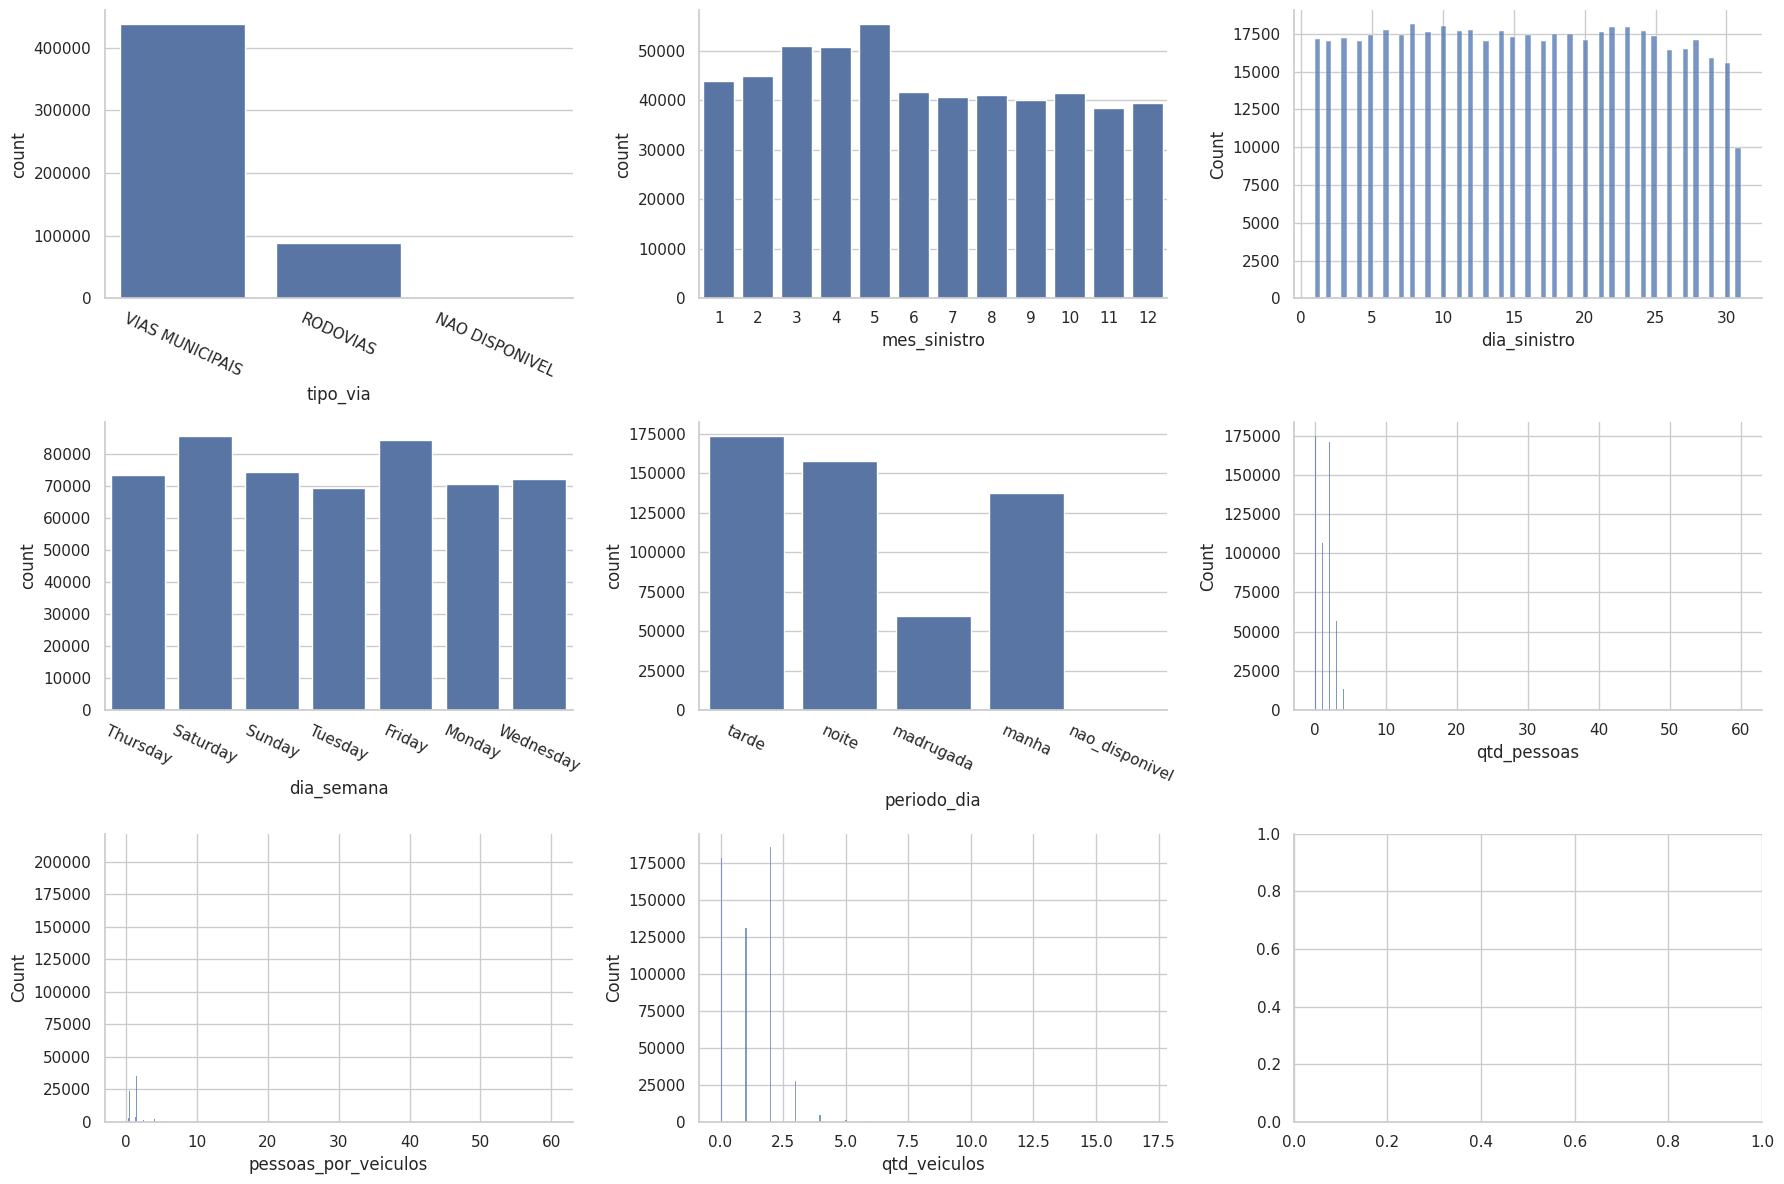

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(18,12))

sns.countplot(ax = ax[0,0], data=X_train, x='tipo_via')
ax[0,0].tick_params(axis='x',rotation=-25)

sns.countplot(ax = ax[0,1], data=X_train, x='mes_sinistro')

sns.histplot(ax = ax[0,2], data=X_train, x='dia_sinistro')

sns.countplot(ax = ax[1,0], data=X_train, x='dia_semana')
ax[1,0].tick_params(axis='x',rotation=-25)

sns.countplot(ax = ax[1,1], data=X_train, x='periodo_dia')
ax[1,1].tick_params(axis='x',rotation=-25)

sns.histplot(ax = ax[1,2], data=X_train, x='qtd_pessoas')

sns.histplot(ax=ax[2,1], data=X_train, x='qtd_veiculos')

sns.histplot(ax = ax[2,0], data=X_train, x='pessoas_por_veiculos')

ax[2,2].set_visible(False)

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

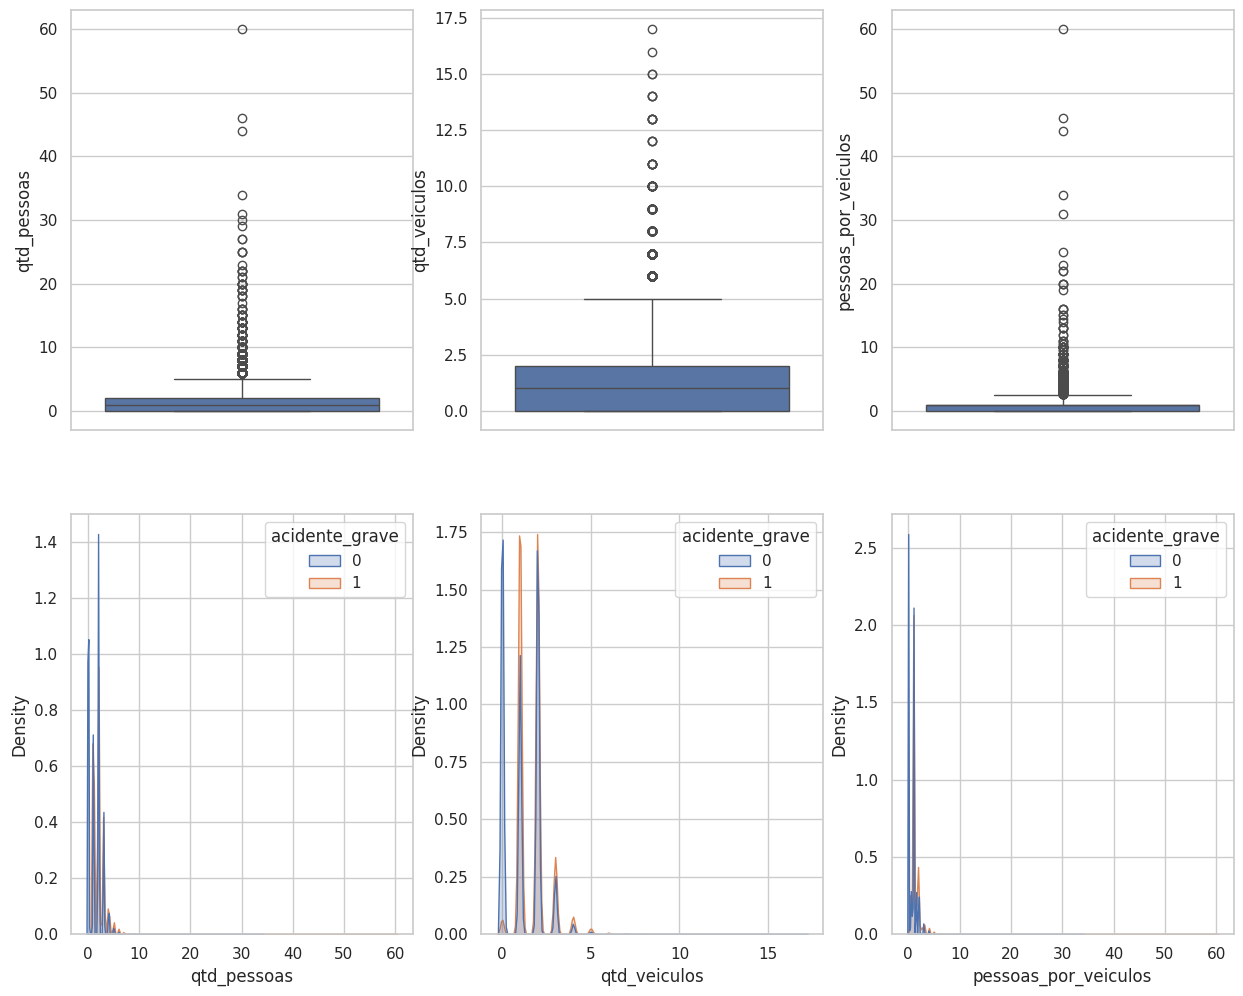

In [ ]:
# Gráficos de features numéricas
## !! Acredito que Pode ser automatizado com .select_dtypes()!!
fig, ax = plt.subplots(2,3, figsize=(15,12))

sns.boxplot(ax = ax[0,0], data=X_train, y='qtd_pessoas')

sns.boxplot(ax = ax[0,1], data=X_train, y='qtd_veiculos')

sns.boxplot(ax = ax[0,2], data=X_train, y='pessoas_por_veiculos')

sns.kdeplot(ax = ax[1,0], data=X_train, x='qtd_pessoas', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1,1], data=X_train, x='qtd_veiculos', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1,2], data=X_train, x='pessoas_por_veiculos', hue=y_train, common_norm=False, fill=True)
plt.show()

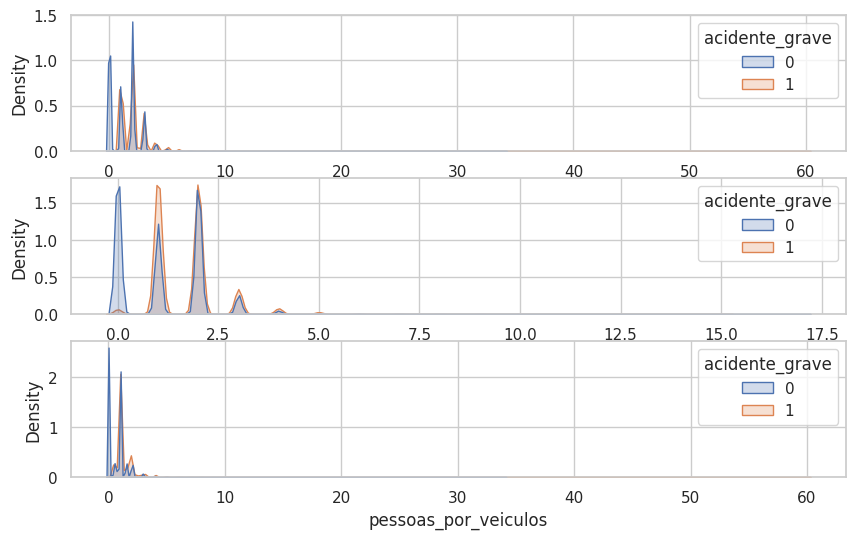

In [28]:
fig, ax = plt.subplots(3,1,figsize=(10,6))

sns.kdeplot(ax = ax[0], data=X_train, x='qtd_pessoas', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1], data=X_train, x='qtd_veiculos', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[2], data=X_train, x='pessoas_por_veiculos', hue=y_train, common_norm=False, fill=True)
plt.show()

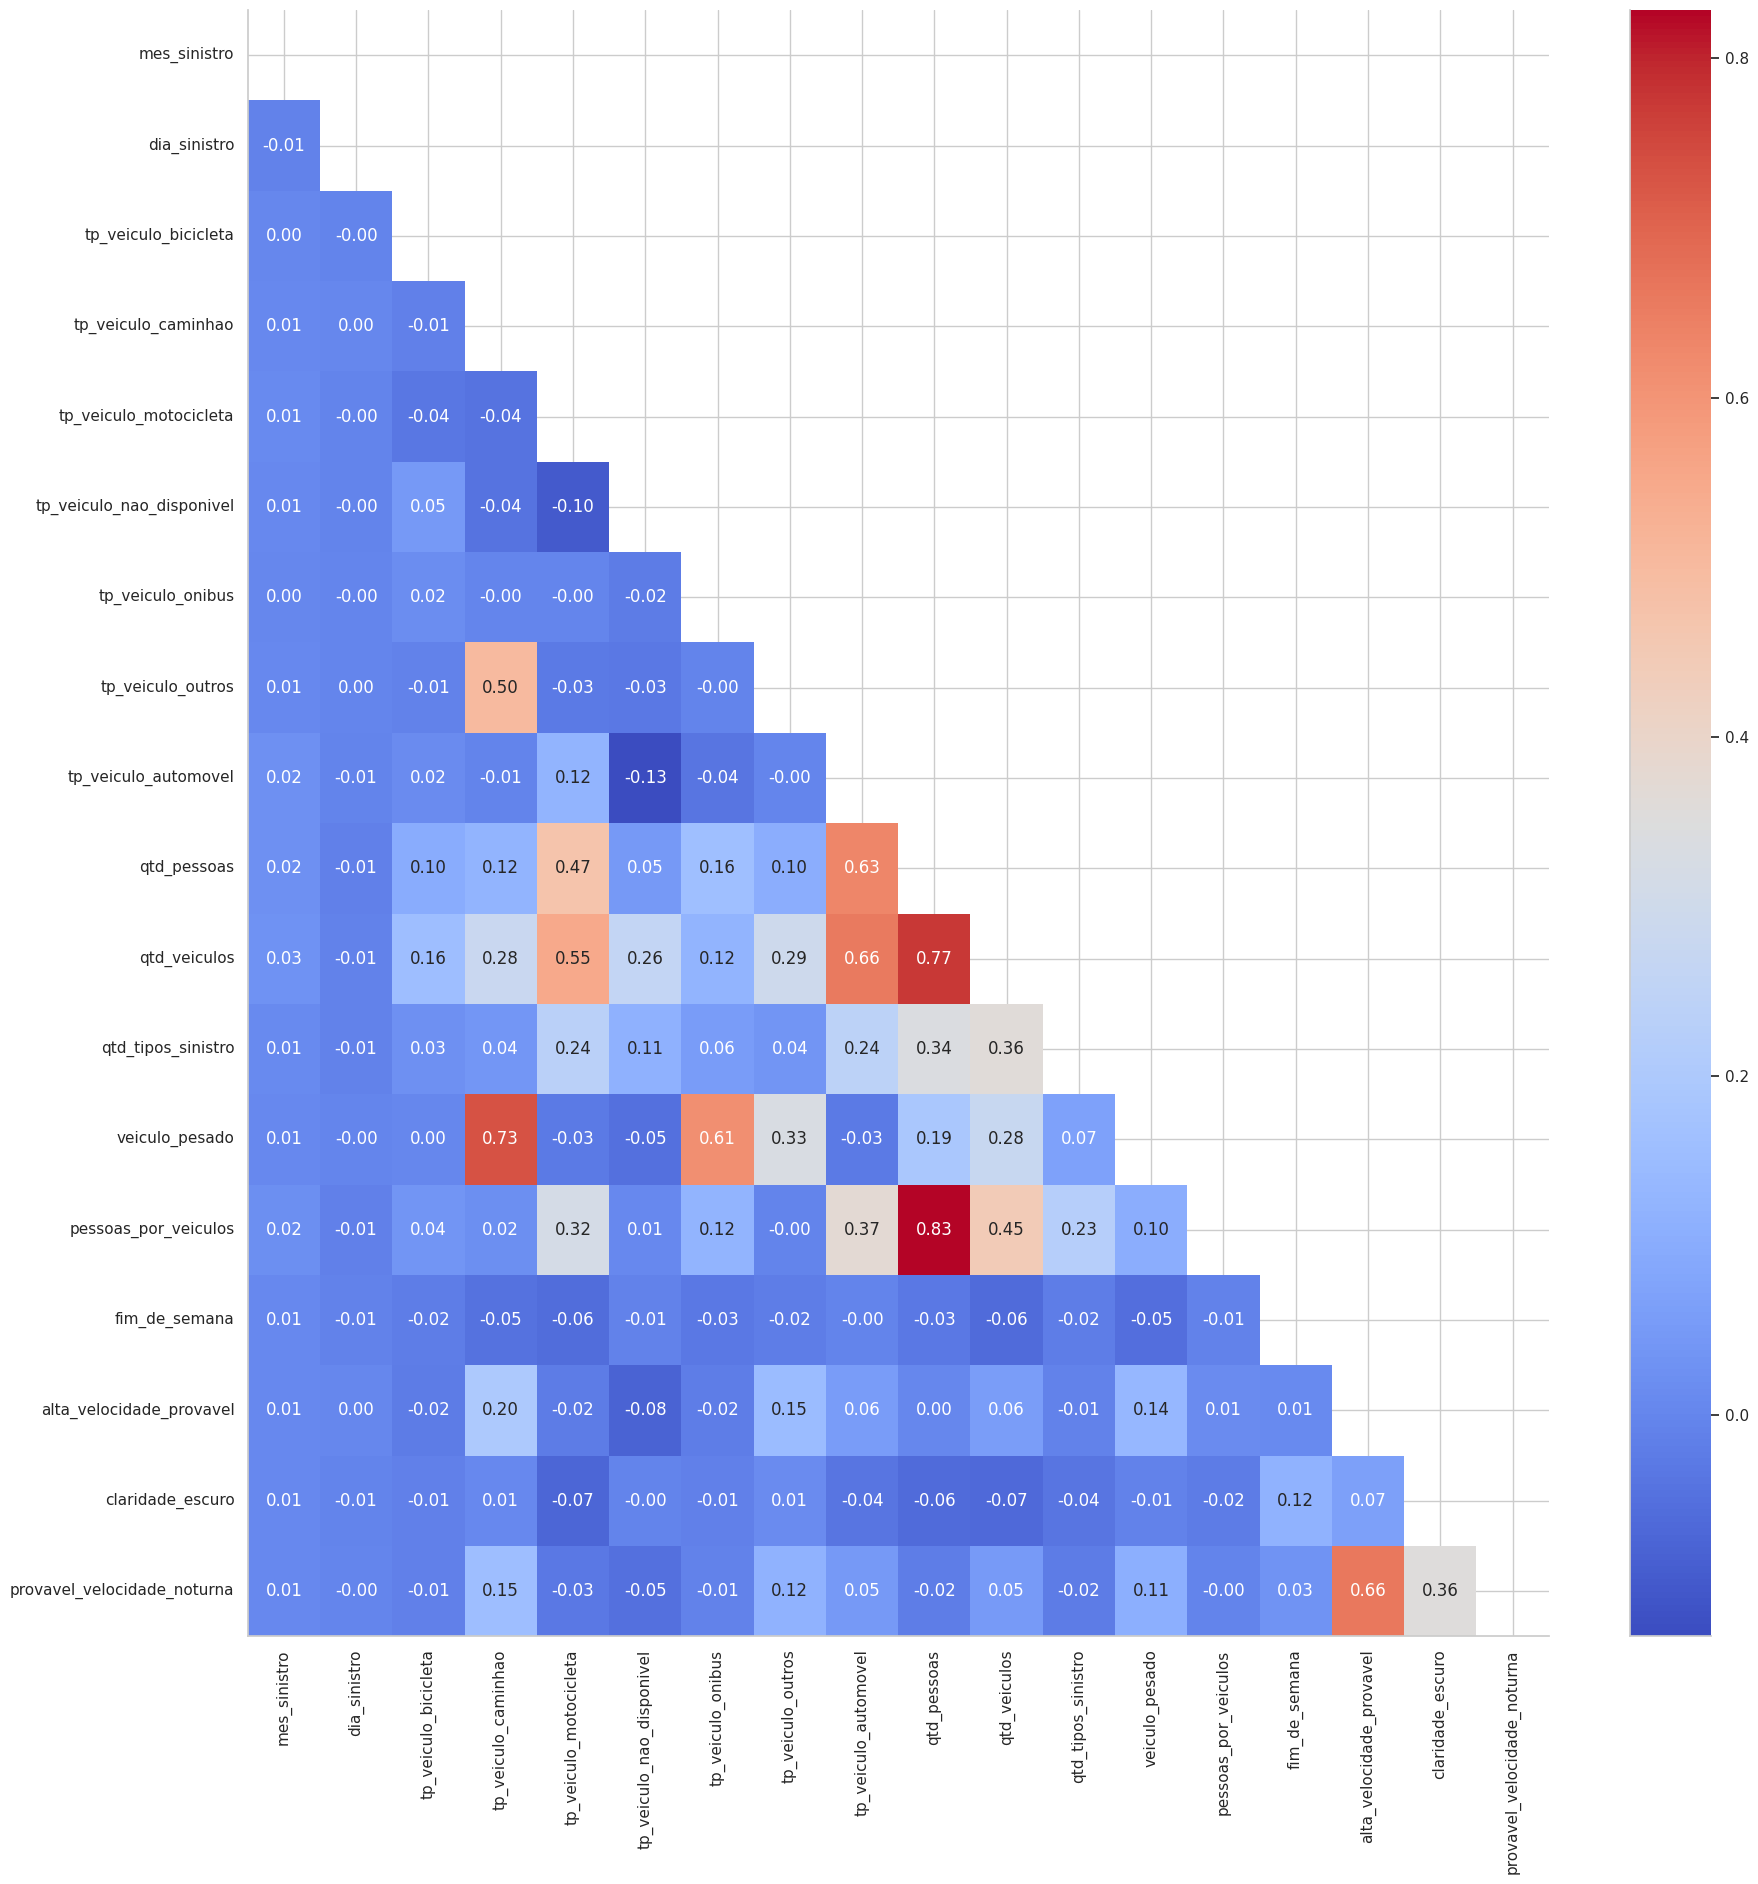

In [29]:
## sem tipos de sinistro
mask = np.triu(np.ones_like(X_train.drop(columns=tipos).corr(numeric_only=True), dtype=bool))
fig, ax = plt.subplots(1,1, figsize=(19,19))
sns.heatmap(data=X_train.drop(columns=tipos).corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            mask=mask, 
            cmap='coolwarm')

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

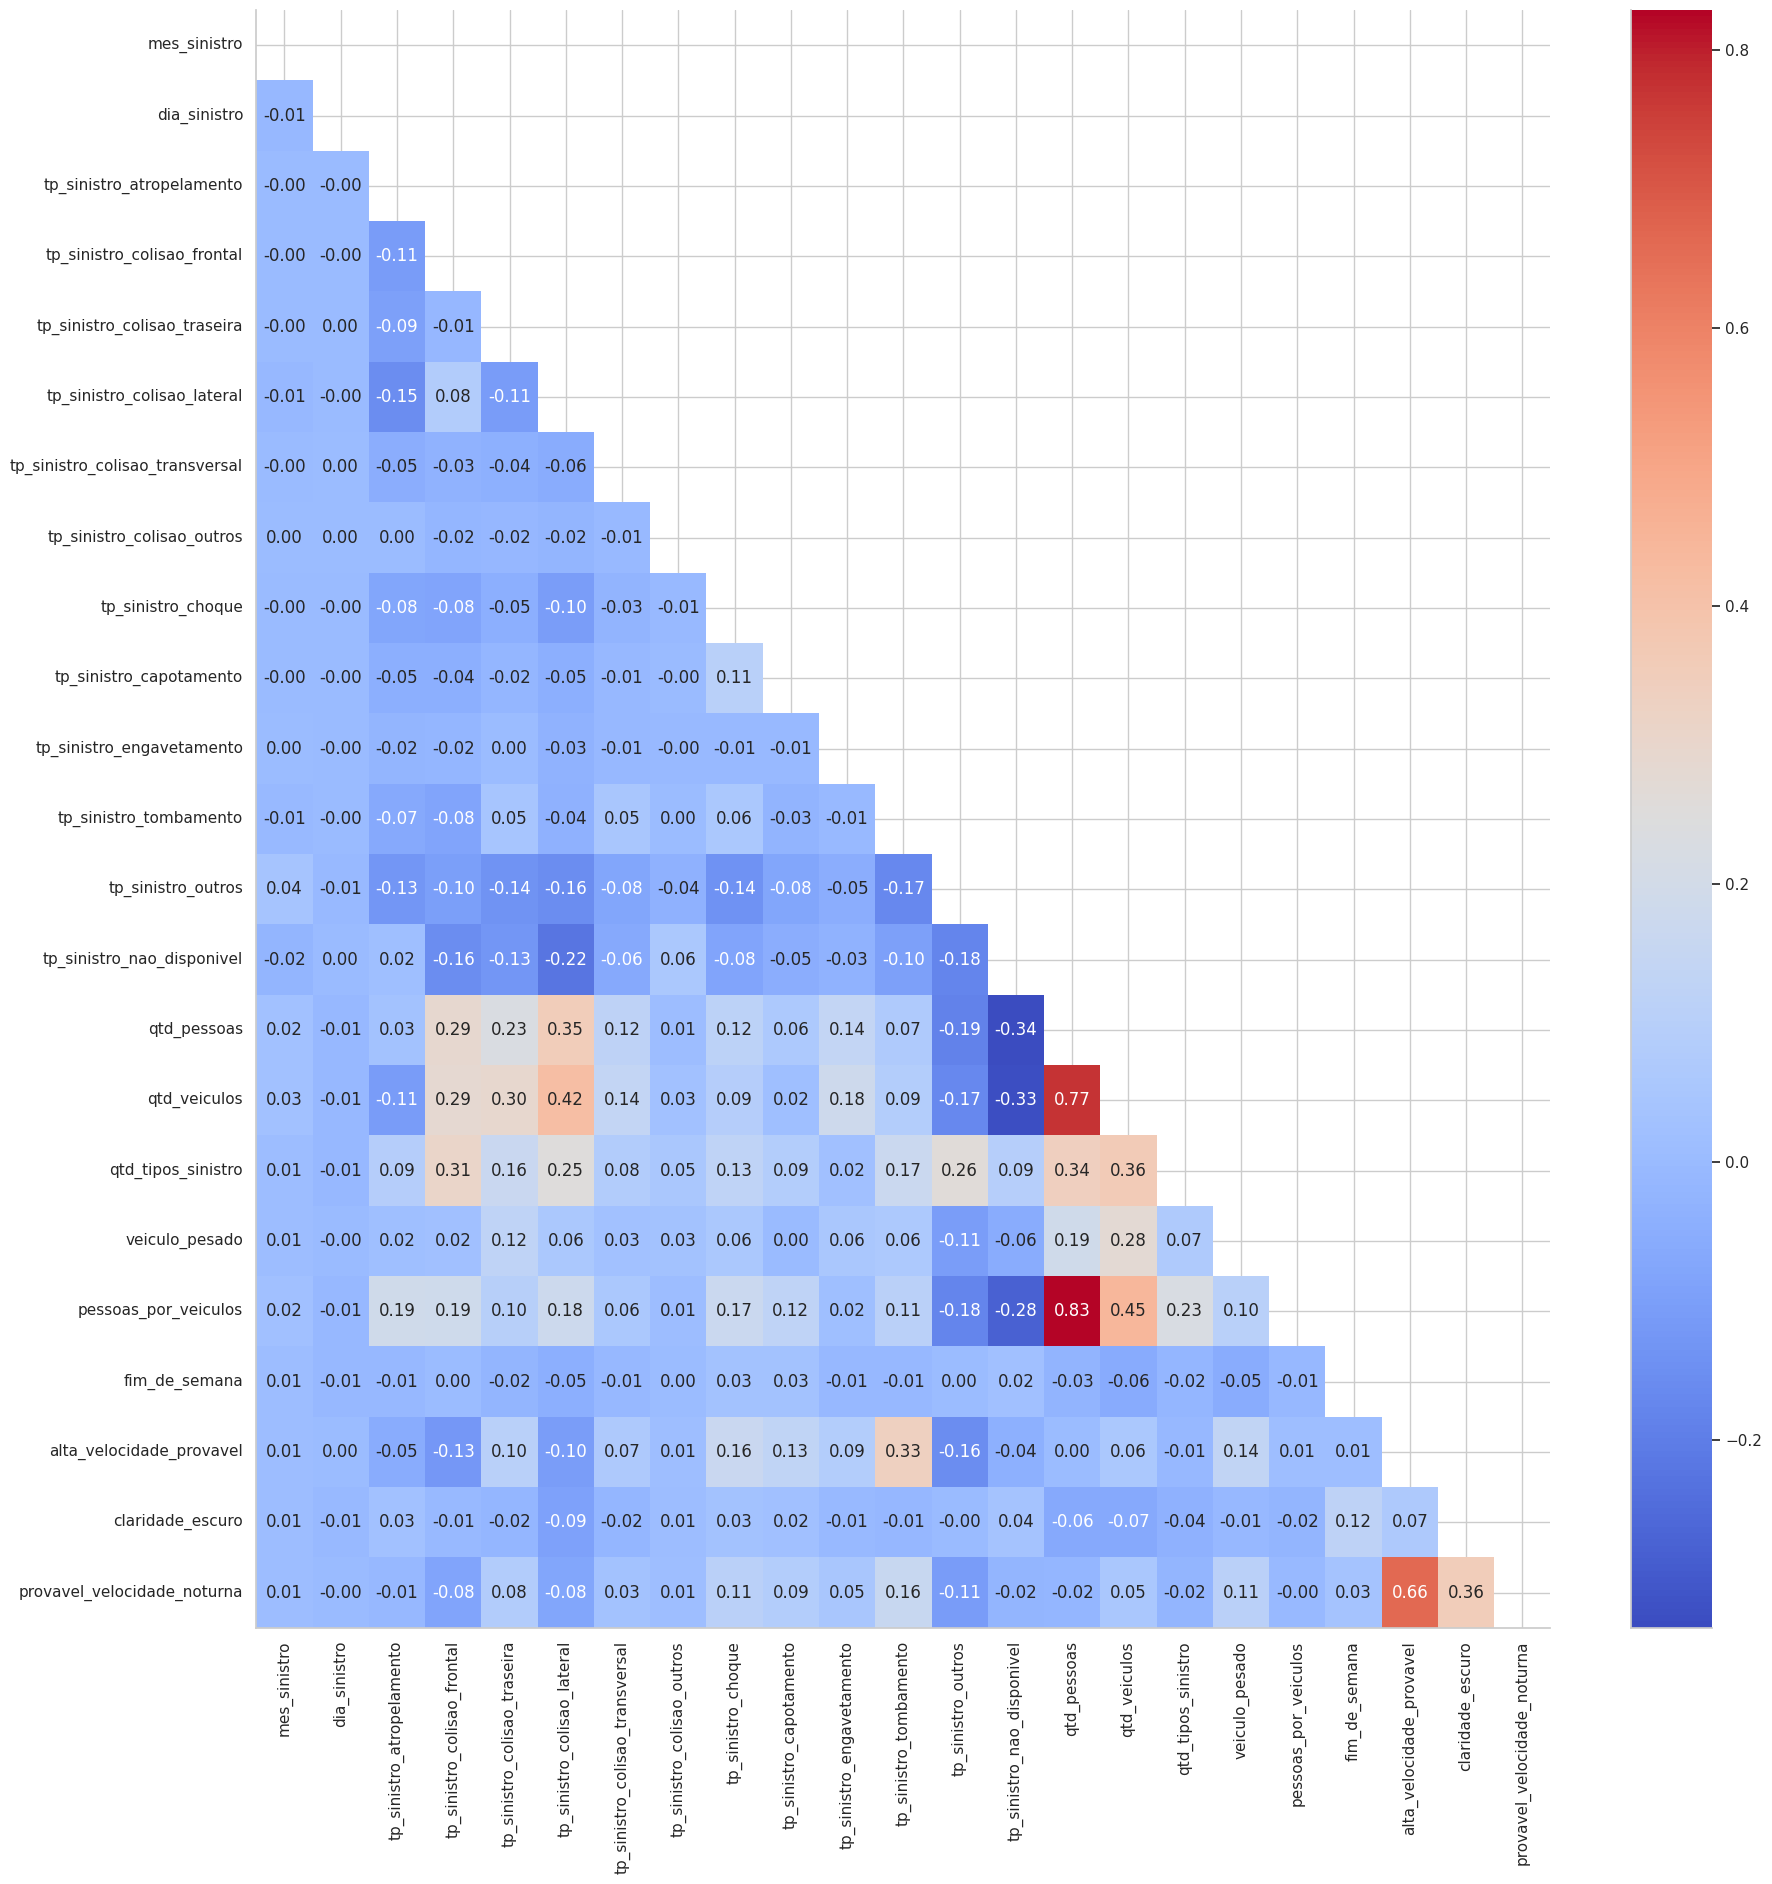

In [30]:
## sem veiculos
mask = np.triu(np.ones_like(X_train.drop(columns=veiculos).corr(numeric_only=True), dtype=bool))
fig, ax = plt.subplots(1,1, figsize=(19,19))
sns.heatmap(data=X_train.drop(columns=veiculos).corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            mask=mask, 
            cmap='coolwarm')

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

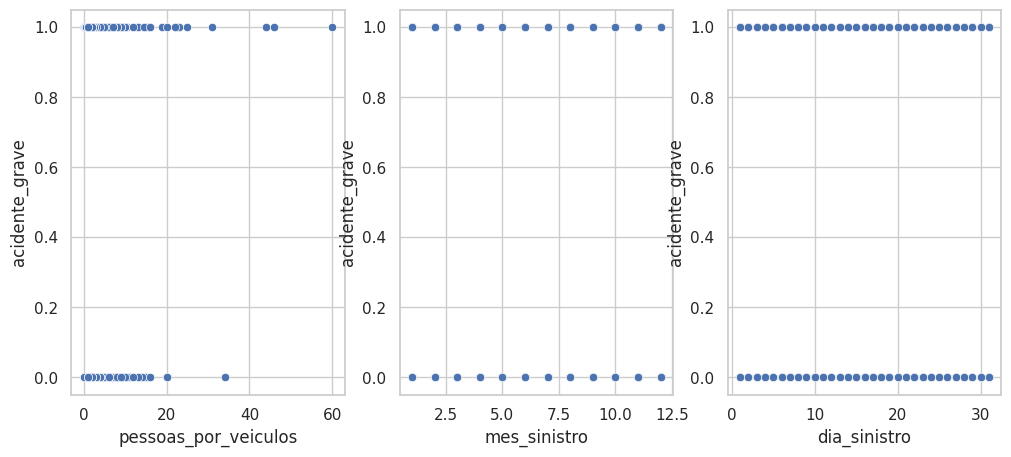

In [31]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

sns.scatterplot(ax = ax[0], x=X_train['pessoas_por_veiculos'], y=y_train)

sns.scatterplot(ax = ax[1], x=X_train['mes_sinistro'], y=y_train)

sns.scatterplot(ax = ax[2], x=X_train['dia_sinistro'], y=y_train)
plt.show()

# treinamento

In [32]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [33]:
num_pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.RobustScaler()),
])

cat_pipeline = pipeline.Pipeline([
    ('input_cat',impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ('num_transformer', num_pipeline, num_cols),
        ('cat_transformer', cat_pipeline, cat_cols),
    ]
)

model = ensemble.RandomForestClassifier(random_state=42,
                                        class_weight='balanced',
                                        max_depth=3,
                                        min_samples_split=6,
                                        n_estimators=6)
# {'model__max_depth': 9, 'model__min_samples_split': 6, 'model__n_estimators': 17}
# {'model__max_depth': 3, 'model__min_samples_split': 10, 'model__n_estimators': 14}
# {'model__max_depth': 4, 'model__min_samples_split': 8, 'model__n_estimators': 6}
# {'model__max_depth': 3, 'model__min_samples_split': 12, 'model__n_estimators': 3}
# {'model__max_depth': 3, 'model__min_samples_split': 6, 'model__n_estimators': 6} -> Best
pipe = pipeline.Pipeline([
    ('preprocessor',preprocessor),
    ('rnd_forest', model)
])


In [38]:
dummy_clf = pipeline.make_pipeline(
    preprocessor,
    dummy.DummyClassifier()
)
dummy_clf.fit(X_train, y_train)
most_frequent = any(dummy_clf.predict(X_train))
print(f'Most frequent class: {most_frequent}')
if most_frequent == False:
    most_frequent = 0
else:
    most_frequent = 1
print(f'Se o modelo chutar {most_frequent} para todas as predições, ele está certo em {(model_selection.cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring='accuracy').mean())}% das vezes')
## 10% são 1
## se o modelo chutar 0 pra tudo ele estará certa em 90% das vezes

Most frequent class: False
Se o modelo chutar 0 para todas as predições, ele está certo em 0.9094147842520094% das vezes


In [35]:
## Melhores Hyperparameters
from scipy.stats import randint

## para RandomSearchCV
param_distribution = {'rnd_forest__max_depth' : randint(low=4, high=15),
                 'rnd_forest__min_samples_split': randint(low=5,high=20),
                 'rnd_forest__n_estimators': randint(low=2,high=20)}
## adicionar n_inter=10

## para GridSearchCV
param_grid = {'rnd_forest__max_depth' : [3,4,7,9],
                 'rnd_forest__min_samples_split': [6,10,12,15],
                 'rnd_forest__n_estimators': [3,6,14,17]}

grid_search = model_selection.GridSearchCV(pipe,
                                                 param_grid=param_grid,
                                                 cv=4,
                                                 scoring='recall',)

grid_search.fit(X_train, y_train)

print('Best params: ',grid_search.best_params_)

Best params:  {'rnd_forest__max_depth': 3, 'rnd_forest__min_samples_split': 6, 'rnd_forest__n_estimators': 6}


In [36]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Sinistro")

with mlflow.start_run(run_name=model.__str__()):
    
    pipe.fit(X_train, y_train)
    y_train_pred = model_selection.cross_val_predict(pipe, X_train, y_train, cv=5)
    y_train_proba = model_selection.cross_val_predict(pipe,X_train, y_train, cv=5, method='predict_proba')

    y_test_pred = pipe.predict(X_test)
    y_test_proba = pipe.predict_proba(X_test)
    
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    matrix = metrics.confusion_matrix(y_train, y_train_pred)
    precision = metrics.precision_score(y_train, y_train_pred)
    recall = metrics.recall_score(y_train, y_train_pred)
    f1_score = metrics.f1_score(y_train, y_train_pred)
    roc_auc = metrics.roc_auc_score(y_train, y_train_pred)
    auc_pr = metrics.average_precision_score(y_train, y_train_proba[:,1])

    recall_test = metrics.recall_score(y_test, y_test_pred)
    auc_pr_test = metrics.average_precision_score(y_test, y_test_proba[:,1])

    print('AUC-PR ', auc_pr)
    print('Accuracy ', accuracy)
    print(matrix)
    print('Precision ',precision)
    print('Recall ',recall)
    print('F1 ',f1_score)
    print('ROC AUC ',roc_auc)
    print(metrics.classification_report(y_test, y_test_pred))

    mlflow.log_metrics({
        'train_Accuracy':accuracy,
        'train_Precision':precision,
        'train_Recall':recall,
        'train_F1':f1_score,
        'train_roc_auc':roc_auc,
        'train_auc_pr':auc_pr,
        'test_recall':recall_test,
        'test_auc_pr':auc_pr_test
    })

MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=Sinistro (Caused by NewConnectionError("HTTPConnection(host='localhost', port=5000): Failed to establish a new connection: [Errno 111] Connection refused"))

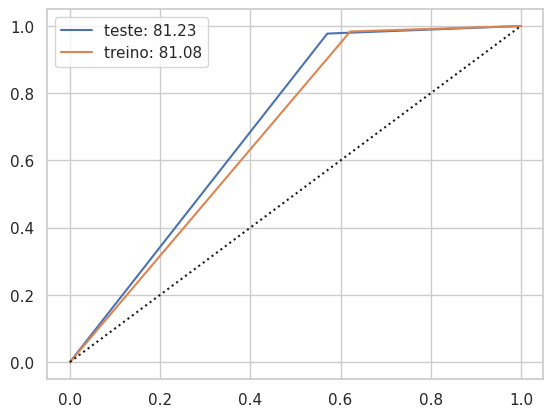

In [ ]:
roc_test = metrics.roc_curve(y_test, y_test_pred)
roc_train = metrics.roc_curve(y_train, y_train_pred)

auc_train = metrics.roc_auc_score(y_train, y_train_proba[:,1])
auc_test = metrics.roc_auc_score(y_test, y_test_proba[:,1])

plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_train[0], roc_train[1])
plt.plot([0, 1], [0, 1], 'k:')

plt.legend([
    f'teste: {100*auc_test:.2f}',
    f'treino: {100*auc_train:.2f}',
])
plt.show()

In [ ]:
best_model = pipe.named_steps['rnd_forest']
features = pipe.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.feature_importances_
features_importances = pd.DataFrame({'feature':features,
                                     'importance':importances}).sort_values(by='importance', 
                                                                            ascending=False)
best_features = features_importances['feature'].head(16).values

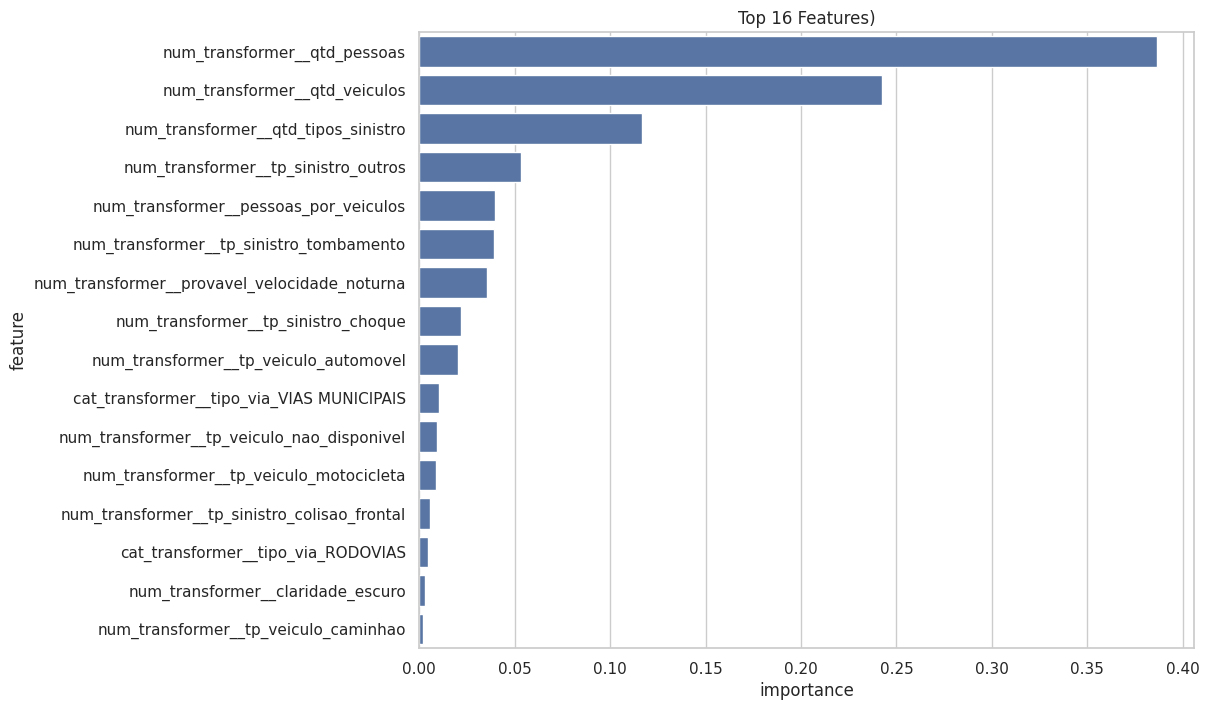

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=features_importances.head(16))
plt.title('Top 16 Features)')
plt.show()

In [ ]:
best_features = [col.replace('num_transformer__','').replace('cat_transformer__','') for col in best_features]
best_features_names = [col for col in best_features if col in X_train.columns]

best_num_cols = X_train[best_features_names].select_dtypes(include=['int64','float64']).columns.tolist()
best_cat_cols = X_train[best_features_names].select_dtypes(include=['object']).columns.tolist()

In [ ]:
num_pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.RobustScaler()),
])

cat_pipeline = pipeline.Pipeline([
    ('input_cat',impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ('num_transformer', num_pipeline, best_num_cols),
        ('cat_transformer', cat_pipeline, best_cat_cols),
    ]
)

model = ensemble.RandomForestClassifier(random_state=42,
                                        class_weight='balanced',
                                        max_depth=8,
                                        min_samples_split=6,
                                        n_estimators=15)

pipe = pipeline.Pipeline([
    ('preprocessor',preprocessor),
    ('rnd_forest', model)
])

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Sinistro")

with mlflow.start_run(run_name=model.__str__()):
    
    pipe.fit(X_train[best_features_names], y_train)
    y_train_pred_best = model_selection.cross_val_predict(pipe, X_train[best_features_names], y_train, cv=3)
    y_train_proba_best = model_selection.cross_val_predict(pipe,X_train[best_features_names], y_train, cv=3, method='predict_proba')

    y_test_pred_best = pipe.predict(X_test[best_features_names])
    y_test_proba_best = pipe.predict_proba(X_test[best_features_names])

    matrix_best = metrics.confusion_matrix(y_train, y_train_pred_best)
    precision_best = metrics.precision_score(y_train, y_train_pred_best)
    recall_best = metrics.recall_score(y_train, y_train_pred_best)
    f1_score_best = metrics.f1_score(y_train, y_train_pred_best)
    auc_pr_best = metrics.average_precision_score(y_train, y_train_proba_best[:,1])

    test_precision_best = metrics.precision_score(y_test, y_test_pred_best)
    test_recall_best = metrics.recall_score(y_test, y_test_pred_best)
    test_auc_pr_best = metrics.average_precision_score(y_test, y_test_proba_best[:,1])


    print('Precision ',precision_best)
    print('Recall ',recall_best)
    print('F1 ',f1_score_best)
    print('AUC-PR ', auc_pr_best)
    print(matrix_best)

    mlflow.log_metrics({
        'train_Precision':precision_best,
        'train_Recall':recall_best,
        'train_F1':f1_score_best,
        'train_auc_pr':auc_pr_best,
        'test_auc_pr': test_auc_pr_best,
        'test_recall': test_recall_best,
        'test_precision': test_precision_best,
    })

Precision  0.17906248795673416
Recall  0.8724780404348098
F1  0.29714135478323894
AUC-PR  0.4594564943751428
[[289459 191716]
 [  6112  41817]]
🏃 View run RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=6, n_estimators=15, random_state=42) at: http://localhost:5000/#/experiments/3/runs/9ee25c837efe4ce7ba6c344453240f56
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [ ]:
y_pred_best = pipe.predict(X_test[best_features_names])
y_proba_best = pipe.predict_proba(X_test[best_features_names])

recall_test = metrics.recall_score(y_test, y_pred_best)
precision_test = metrics.precision_score(y_test, y_pred_best)
auc_pr_test = metrics.average_precision_score(y_test, y_proba_best[:,1])

print('recall ', recall_test)
print('precision ', precision_test)
print('auc_pr ', auc_pr_test)

recall  0.8833249874812218
precision  0.17652651066597727
auc_pr  0.4515613965726519


In [ ]:
y_probas_best = model_selection.cross_val_predict(pipe, X_train[best_features_names], y_train, cv=3, method='predict_proba')[:,1]
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_probas_best)

min_recall = 0.9
mask = recalls[:-1] >= min_recall

best_index = np.argmax(precisions[:-1][mask])
best_threshold = thresholds[mask][best_index]

print(best_threshold)

0.48741378189892104


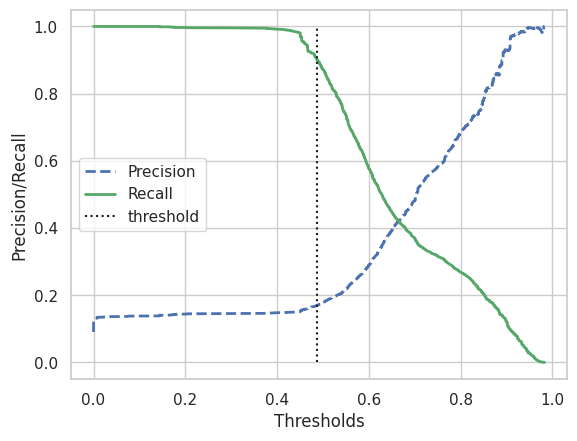

In [ ]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(best_threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.xlabel('Thresholds')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
# Obter probabilidades no teste
y_probs_test = pipe.predict_proba(X_test[best_features_names])[:, 1]

# Aplicar o novo threshold (ex: 0.62) em vez do padrão 0.5
y_pred_custom = (y_probs_test >= best_threshold).astype(int)

# Gerar o relatório final
print(metrics.classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.98      0.57      0.72    120294
           1       0.17      0.90      0.29     11982

    accuracy                           0.60    132276
   macro avg       0.58      0.73      0.50    132276
weighted avg       0.91      0.60      0.68    132276

